## Importing dependencies

In [79]:
import itertools
import warnings
import statsmodels.api as sm
import datetime
from statsmodels.tsa.arima_model import ARIMA

## RL dependencies

In [85]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines import PPO2
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from gym import spaces

## Processing dependencies

In [2]:
import numpy as np
import pandas as pnd
from matplotlib import pyplot as plt

In [6]:
df = pnd.read_csv('datasets/F.csv')
df.head()

,date,volume,open,close,high,low,adjclose
0,2018-11-02,48495800,9.36,9.38,9.45,9.26,9.38
1,2018-11-01,59794400,9.54,9.29,9.55,9.26,9.29
2,2018-10-31,68507100,9.62,9.55,9.67,9.43,9.55
3,2018-10-30,58062000,9.31,9.46,9.56,9.27,9.46
4,2018-10-29,92275100,9.36,9.28,9.59,9.17,9.28


In [7]:
df['date'] = pnd.to_datetime(df['date'], format='%Y-%m-%d')
df.dtypes

date        datetime64[ns]
volume               int64
open               float64
close              float64
high               float64
low                float64
adjclose           float64
dtype: object

In [6]:
df.isnull().sum()

date        0
volume      0
open        0
close       0
high        0
low         0
adjclose    0
dtype: int64

In [8]:
df.sort_values('date', ascending=True, inplace=True)
df.head()

,date,volume,open,close,high,low,adjclose
11710,1972-06-01,1089200,2.149165,2.153220,2.173495,2.149165,0.003095
11709,1972-06-02,1173500,2.153220,2.149165,2.173495,2.141055,0.003089
11708,1972-06-05,5208100,2.149165,2.149165,2.169440,2.141055,0.003089
11707,1972-06-06,1421400,2.149165,2.124835,2.157275,2.116725,0.003054
11706,1972-06-07,671800,2.124835,2.112669,2.137000,2.112669,0.003037


In [9]:
df.date.dt.to_period('M')

11710    1972-06
11709    1972-06
11708    1972-06
11707    1972-06
11706    1972-06
          ...   
4        2018-10
3        2018-10
2        2018-10
1        2018-11
0        2018-11
Name: date, Length: 11711, dtype: period[M]

In [10]:
df.drop(columns=['adjclose'], inplace=True)

In [11]:
df = df.groupby(pnd.DatetimeIndex(df.date).to_period('M')).nth(0)
df.drop(columns=['date'], inplace=True)

In [11]:
df.tail()

,volume,open,close,high,low
date,,,,,
2018-07,37892800,11.02,11.10,11.11,10.91
2018-08,44126700,10.06,9.90,10.08,9.82
2018-09,54111100,9.53,9.47,9.58,9.36
2018-10,44864700,9.43,9.32,9.44,9.30
2018-11,59794400,9.54,9.29,9.55,9.26


In [12]:
# df.set_index('date', inplace=True)

In [13]:
start_date = pnd.to_datetime('2015-01')
print(type(start_date))
end_date = pnd.to_datetime('2020-01')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Preparing close set

In [14]:
train_data_close = df['2000-01':'2015-01']
train_data_close.drop(columns=['open', 'high', 'volume', 'low'], inplace=True)
test_data_close = df['2015-01':'2020-01']
test_data_close.drop(columns=['open', 'high', 'volume', 'low'], inplace=True)
print('test_data_close length: ', len(test_data_close), 'train_data_close length:', len(train_data_close), 'whole set:', len(df))
train_data_close.tail()

test_data_close length:  47 train_data_close length: 181 whole set: 558


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,close
date,
2014-09,17.60
2014-10,14.59
2014-11,13.99
2014-12,15.77
2015-01,15.36


### Preparing low set

In [15]:
train_data_low = df['2000-01':'2015-01']
train_data_low.drop(columns=['open', 'high','volume', 'close'], inplace=True)
test_data_low = df['2015-01':'2020-01']
test_data_low.drop(columns=['open', 'high','volume', 'close'], inplace=True)
print('test_data_low length: ', len(test_data_low), 'train_data_low length:', len(train_data_low), 'whole set:', len(df))
train_data_low.tail()

test_data_low length:  47 train_data_low length: 181 whole set: 558


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,low
date,
2014-09,17.48
2014-10,14.56
2014-11,13.94
2014-12,15.70
2015-01,15.18


### Preparing high set

In [16]:
train_data_high = df['2000-01':'2015-01']
train_data_high.drop(columns=['open', 'low','volume', 'close'], inplace=True)
test_data_high = df['2015-01':'2020-01']
test_data_high.drop(columns=['open', 'low','volume', 'close'], inplace=True)
print('test_data_high length: ', len(test_data_high), 'train_data_high length:', len(train_data_high), 'whole set:', len(df))
train_data_high.tail()

test_data_high length:  47 train_data_high length: 181 whole set: 558


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,high
date,
2014-09,17.620001
2014-10,14.830000
2014-11,14.170000
2014-12,15.890000
2015-01,15.650000


### Preparing open set

In [17]:
train_data_open = df['2000-01':'2015-01']
train_data_open.drop(columns=['high', 'low','volume', 'close'], inplace=True)
test_data_open = df['2015-01':'2020-01']
test_data_open.drop(columns=['high', 'low','volume', 'close'], inplace=True)
print('test_data_open length: ', len(test_data_open), 'train_data_open length:', len(train_data_open), 'whole set:', len(df))
train_data_open.tail()

test_data_open length:  47 train_data_open length: 181 whole set: 558


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,open
date,
2014-09,17.48
2014-10,14.77
2014-11,14.10
2014-12,15.78
2015-01,15.59


## ARIMA Model

In [18]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data_close,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [20]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 436.0183165459671 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


### ARIMA for close

In [26]:
# mod_close = ARIMA(train_data_close,order=(3,2,1))
# results_close = mod_close.fit(disp=-1)

# Let's fit this model
mod_close = sm.tsa.statespace.SARIMAX(train_data_close,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_close = mod_close.fit()

In [15]:
frame = np.zeros((4, 40 + 1))
current_step
print(frame)
np.put(frame, [0, 3], [
            df.loc[current_step: 40 + 1, 'open'].values / MAX_SHARE_PRICE,
            df.loc[current_step: 40 + 1, 'high'].values / MAX_SHARE_PRICE,
            df.loc[current_step: 40 + 1, 'low'].values / MAX_SHARE_PRICE,
            df.loc[current_step: 40 + 1, 'close'].values / MAX_SHARE_PRICE,
        ])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


KeyError: "Cannot interpret 'open' as period"

### ARIMA for open

In [27]:
# mod_open = ARIMA(train_data_open,order=(3,1,1))
# results_open = mod_open.fit(disp=-1)

mod_open = sm.tsa.statespace.SARIMAX(train_data_open,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_open = mod_open.fit()

### ARIMA for low

In [28]:
# mod_low = ARIMA(train_data_low,order=(3,1,1))
# results_low = mod_low.fit(disp=-1)

mod_low = sm.tsa.statespace.SARIMAX(train_data_low,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_low = mod_low.fit()

### ARIMA for high

In [29]:
# mod_high = ARIMA(train_data_high,order=(3,2,1))
# results_high = mod_high.fit(disp=-1)

mod_high = sm.tsa.statespace.SARIMAX(train_data_high,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_high = mod_high.fit()

## ARIMA Prediction

### Close ARIMA

In [30]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_close = results_close.get_forecast(end_date)
pred_close_ci = pred_close.conf_int()
fc_series_close = pred_close.predicted_mean
# lower_series_close = pnd.Series(conf[:, 0], index=index)
# upper_series_close = pnd.Series(conf[:, 1], index=index)

### Open ARIMA

In [31]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_open = results_open.get_forecast(end_date)
pred_open_ci = pred_open.conf_int()
fc_series_open = pred_open.predicted_mean
# lower_series_open = pnd.Series(conf[:, 0], index=index)
# upper_series_open = pnd.Series(conf[:, 1], index=index)

### Low ARIMA

In [32]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_low = results_low.get_forecast(end_date)
pred_low_ci = pred_low.conf_int()
fc_series_low = pred_low.predicted_mean
# lower_series_low = pnd.Series(conf[:, 0], index=index)
# upper_series_low = pnd.Series(conf[:, 1], index=index)

### High ARIMA

In [33]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_high = results_high.get_forecast(end_date)
pred_high_ci = pred_high.conf_int()
fc_series_high = pred_high.predicted_mean
# lower_series_high = pnd.Series(conf[:, 0], index=index)
# upper_series_chigh = pnd.Series(conf[:, 1], index=index)

## SARIMAX Plot and test plot comparison

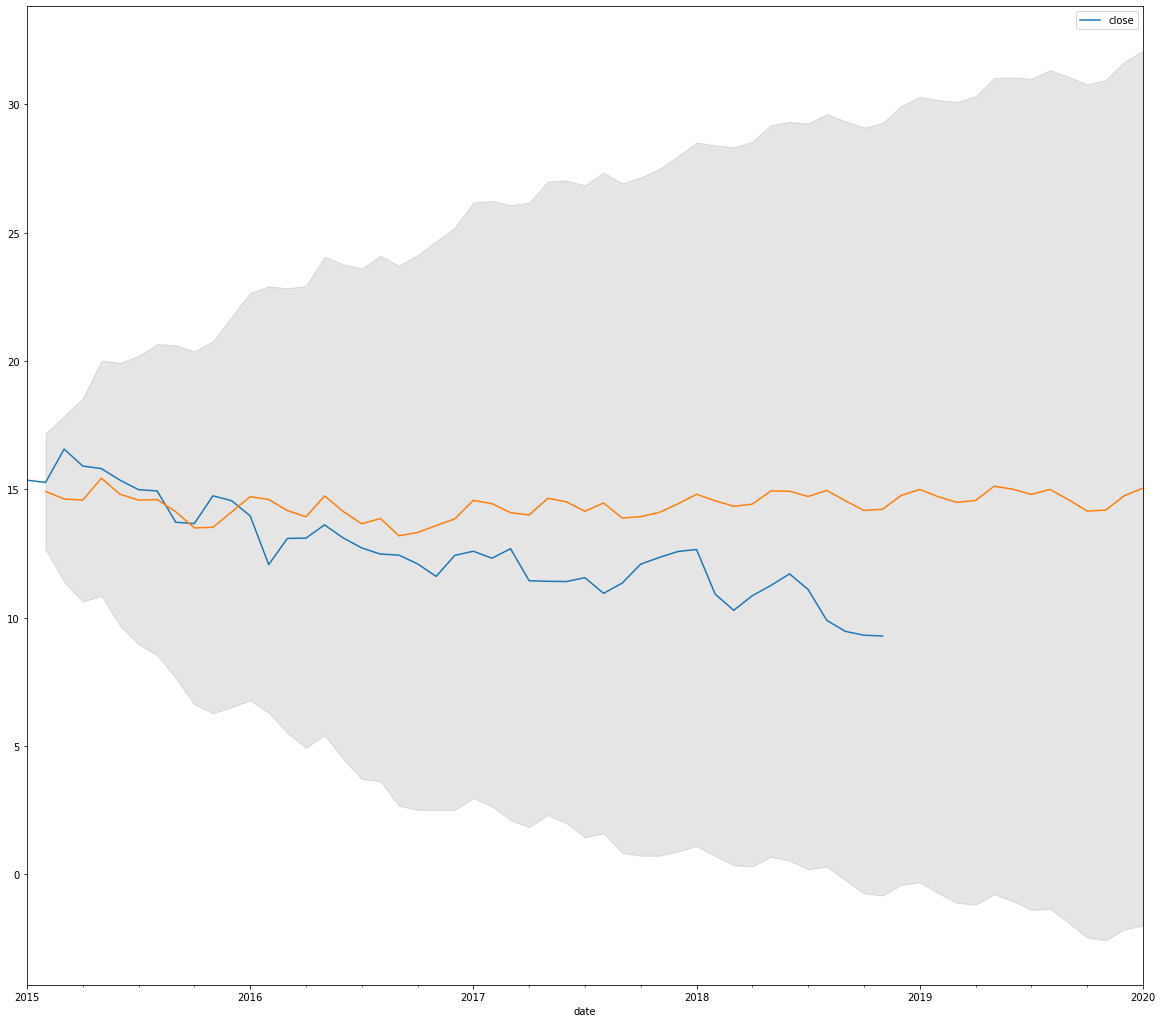

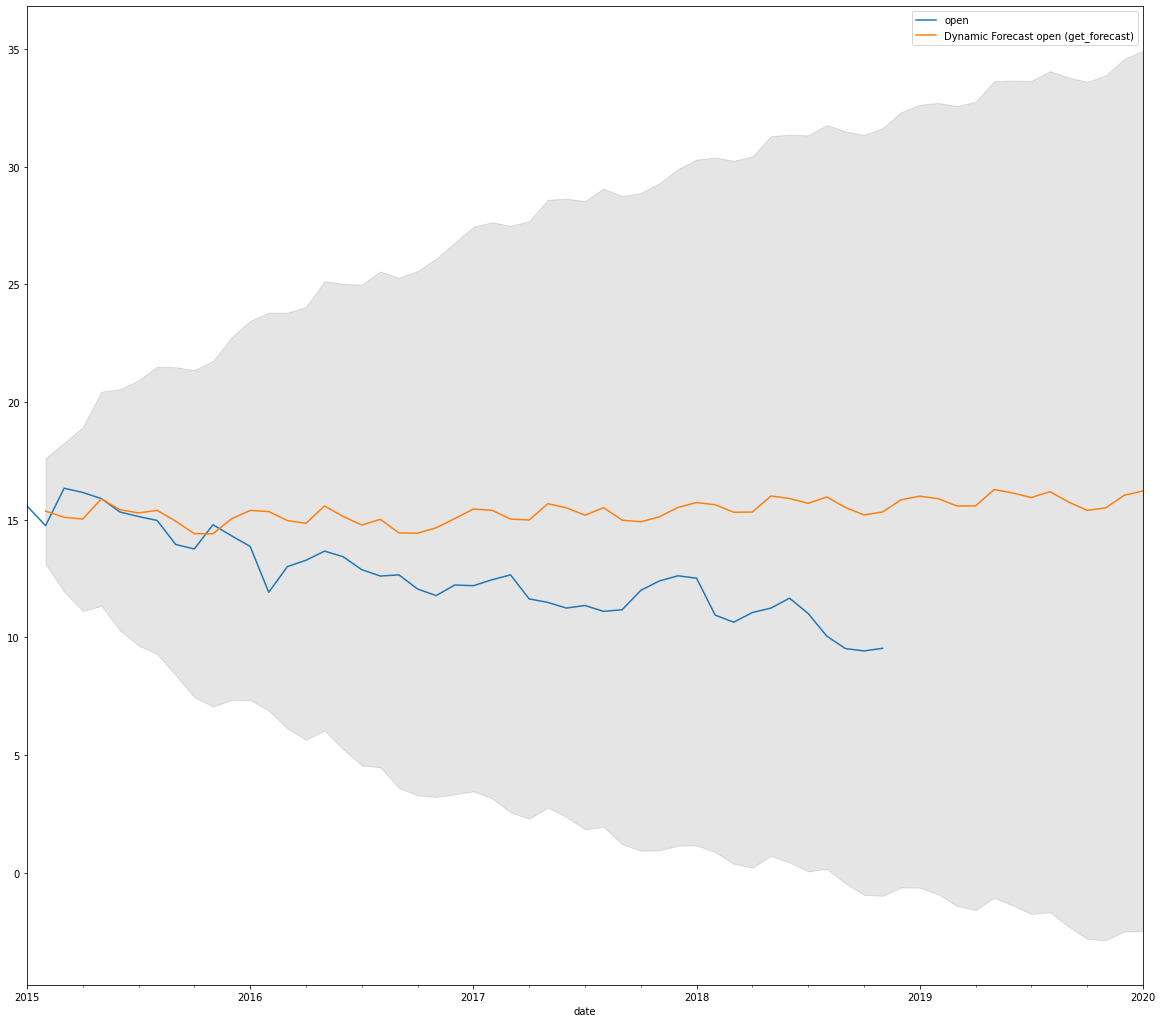

In [29]:
ax = test_data_close.plot(y='close',figsize=(20, 18))
bx = test_data_open.plot(y='open',figsize=(20, 18))
pred_close.predicted_mean.plot(ax=ax, label='Dynamic Forecast close (get_forecast)')
pred_open.predicted_mean.plot(ax=bx, label='Dynamic Forecast open (get_forecast)')
ax.fill_between(pred_close_ci.index, pred_close_ci.iloc[:, 0], pred_close_ci.iloc[:, 1], color='k', alpha=.1)
bx.fill_between(pred_open_ci.index, pred_open_ci.iloc[:, 0], pred_open_ci.iloc[:, 1], color='k', alpha=.1)
# plt.plot(fc_series_close, label='forecast_close')
# plt.plot(fc_series_open, label='forecast_open')
# plt.plot(fc_series_low, label='forecast_low')
# plt.plot(fc_series_high, label='forecast_high')
# plt.xlim(left=start_date, right=end_date)
# plt.ylabel('close')
# plt.fill_between(lower_series_close.index, lower_series_close, upper_series_close, 
#                  color='k', alpha=.15)
# plt.fill_between(lower_series_low.index, lower_series_low, upper_series_low, 
#                  color='k', alpha=.15)
plt.xlabel('date')
plt.legend()
plt.show()

## Generating new Dataframe with forecast

In [36]:
print(len(index), len(fc_series_close))
frame = {'date': index, 'close':fc_series_close, 'low': fc_series_low, 'open': fc_series_open, 'high': fc_series_high}
new_df = pnd.DataFrame(frame)
new_df = new_df.reset_index()
new_df.head()

60 60


,index,date,close,low,open,high
0,2015-02,2015-01,14.922086,14.713516,15.368960,15.322763
1,2015-03,2015-02,14.625451,14.745822,15.106119,15.050239
2,2015-04,2015-03,14.585823,15.188419,15.032342,15.056161
3,2015-05,2015-04,15.436712,15.196485,15.890716,15.840862
4,2015-06,2015-05,14.810465,15.255937,15.426893,15.384007


In [157]:
from finta import TA

new_df['SMA'] = TA.SMA(new_df, 12)
new_df['RSI'] = TA.RSI(new_df)
new_df['MACD'] = 0
new_df['MOM'] = TA.MOM(new_df)
new_df['MACD'] = TA.MACD(new_df)
new_df['EMA'] = TA.EMA(new_df)
new_df.fillna(0, inplace=True)


In [153]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 10000

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['low','SMA', 'RSI', 'MACD','MOM', 'EMA']].to_numpy()[start:end]
    return prices, signal_features


def stock_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['close', 'open', 'high', 'low']].to_numpy()[start:end]
    return prices, signal_features


class StockTradingEnv(StocksEnv):
    _process_data = add_signals
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super(StockTradingEnv, self).__init__(**kwargs)
        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
          low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
          low=0, high=1, shape=(6, 6), dtype=np.float16)

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, 'Open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([
        self.df.loc[self.current_step: self.current_step +
                    5, 'Open'].values / MAX_SHARE_PRICE,
        self.df.loc[self.current_step: self.current_step +
                    5, 'High'].values / MAX_SHARE_PRICE,
        self.df.loc[self.current_step: self.current_step +
                    5, 'Low'].values / MAX_SHARE_PRICE,
        self.df.loc[self.current_step: self.current_step +
                    5, 'Close'].values / MAX_SHARE_PRICE,
        self.df.loc[self.current_step: self.current_step +
                    5, 'Volume'].values / MAX_NUM_SHARES,
        ])
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[
        self.balance / MAX_ACCOUNT_BALANCE,
        self.max_net_worth / MAX_ACCOUNT_BALANCE,
        self.shares_held / MAX_NUM_SHARES,
        self.cost_basis / MAX_SHARE_PRICE,
        self.total_shares_sold / MAX_NUM_SHARES,
        self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
        ]], axis=0)
        return obs
    
    def _process_data(self):
        return self._prices, self._signal_features

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
            self.current_step = 0
        delay_modifier = (self.current_step / MAX_STEPS)

        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
          # Set the current price to a random price within the time step
        current_price = random.uniform(
        self.df.loc[self.current_step, "Open"],
            self.df.loc[self.current_step, "Close"])
        action_type = action[0]
        amount = action[1]
        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = self.balance / current_price
            shares_bought = total_possible * amount
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price
            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought
        elif actionType < 2:
            # Sell amount % of shares held
            shares_sold = self.shares_held * amount
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price
            self.netWorth = self.balance + self.shares_held * current_price
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = net_worth
        if self.shares_held == 0:
            self.cost_basis = 0
            
    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}(Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis}(Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth}(Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [160]:
prices, signal_features = stock_process_data(df=new_df, window_size=30, frame_bound=(30, len(new_df)))
env2 = StockTradingEnv(prices, signal_features, df=new_df, frame_bound=(30, len(new_df)), window_size=6)

In [161]:
env2.signal_features

array([[14.9220863 , 15.36895972, 15.3227634 , 14.71351598],
       [14.62545083, 15.10611927, 15.05023931, 14.74582195],
       [14.58582346, 15.03234181, 15.05616097, 15.188419  ],
       [15.43671246, 15.89071597, 15.84086224, 15.19648496],
       [14.81046515, 15.42689252, 15.3840066 , 15.25593733],
       [14.58168107, 15.29039496, 15.19684907, 15.28662627],
       [14.60409067, 15.40064143, 15.3187485 , 15.07364253],
       [14.12745972, 14.93896256, 14.82271126, 15.04874456],
       [13.49873685, 14.41141672, 14.26518833, 13.72343471],
       [13.52368239, 14.40522135, 14.2051072 , 14.00391992],
       [14.11931491, 15.04447992, 14.83549535, 14.84895018],
       [14.71857798, 15.39709726, 15.25368231, 14.8177168 ],
       [14.60688986, 15.34883106, 15.15151041, 14.69784755],
       [14.17385326, 14.96715938, 14.78898081, 14.69530234],
       [13.93180389, 14.84910627, 14.63272603, 15.09228627],
       [14.74657574, 15.58815511, 15.37078249, 14.96961523],
       [14.14017167, 15.

In [156]:
env2.action_space

Box(0.0, 3.0, (2,), float16)

In [158]:
new_df.head(15)

,close,low,open,high,SMA,RSI,MACD,EMA,MOM
date,,,,,,,,,
2015-01,14.922086,14.713516,15.368960,15.322763,0.000000,0.000000,0.000000,14.922086,0.000000
2015-02,14.625451,14.745822,15.106119,15.050239,0.000000,0.000000,-0.006655,14.757289,0.000000
2015-03,14.585823,15.188419,15.032342,15.056161,0.000000,0.000000,-0.009709,14.687016,0.000000
2015-04,15.436712,15.196485,15.890716,15.840862,0.000000,74.413647,0.019861,14.940978,0.000000
2015-05,14.810465,15.255937,15.426893,15.384007,0.000000,46.806705,0.010591,14.902154,0.000000
2015-06,14.581681,15.286626,15.290395,15.196849,0.000000,40.845015,-0.004963,14.815288,0.000000
2015-07,14.604091,15.073643,15.400641,15.318749,0.000000,41.629256,-0.013838,14.761839,0.000000
2015-08,14.127460,15.048745,14.938963,14.822711,0.000000,31.932544,-0.042235,14.609386,0.000000
2015-09,13.498737,13.723435,14.411417,14.265188,0.000000,23.993322,-0.092450,14.352821,0.000000


In [147]:
import os

from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec
from stable_baselines.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                    self.model.save(self.save_path)

        return True

In [159]:
env2.signal_features

array([[14.9220863 , 15.36895972, 15.3227634 , 14.71351598],
       [14.62545083, 15.10611927, 15.05023931, 14.74582195],
       [14.58582346, 15.03234181, 15.05616097, 15.188419  ],
       [15.43671246, 15.89071597, 15.84086224, 15.19648496],
       [14.81046515, 15.42689252, 15.3840066 , 15.25593733],
       [14.58168107, 15.29039496, 15.19684907, 15.28662627],
       [14.60409067, 15.40064143, 15.3187485 , 15.07364253],
       [14.12745972, 14.93896256, 14.82271126, 15.04874456],
       [13.49873685, 14.41141672, 14.26518833, 13.72343471],
       [13.52368239, 14.40522135, 14.2051072 , 14.00391992],
       [14.11931491, 15.04447992, 14.83549535, 14.84895018],
       [14.71857798, 15.39709726, 15.25368231, 14.8177168 ],
       [14.60688986, 15.34883106, 15.15151041, 14.69784755],
       [14.17385326, 14.96715938, 14.78898081, 14.69530234],
       [13.93180389, 14.84910627, 14.63272603, 15.09228627],
       [14.74657574, 15.58815511, 15.37078249, 14.96961523],
       [14.14017167, 15.

In [149]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [150]:
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
model = PPO2('MlpPolicy', env, verbose=1)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model.learn(total_timesteps=100000, callback=callback)

AttributeError: 'DummyVecEnv' object has no attribute 'reward_range'

In [131]:
model.save('stock_traiding_model')


In [132]:
del model

In [134]:
model = PPO2.load("stock_traiding_model")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [141]:
env = aapl_custom_env(df=new_df, window_size=10, frame_bound=(10,len(new_df)))
obs = env.reset()

# obs_first = obs[np.newaxis, ...] 
# action, _states = model.predict(obs_first)
# obs, rewards, done, info = env.step(action)
# print(obs, done)
# obs_second = obs[np.newaxis, ...]
# action, _states = model.predict(obs_second)
# obs, rewards, done, info = env.step(action)
# print(obs)
# print('info', info)
while True:
#     action, _states = model.predict(obs)
#     obs, rewards, done, info = env.step(action)
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print('info', info)
        break

info {'total_reward': 8.202969531841456, 'total_profit': 1.3991349252424847, 'position': 0}


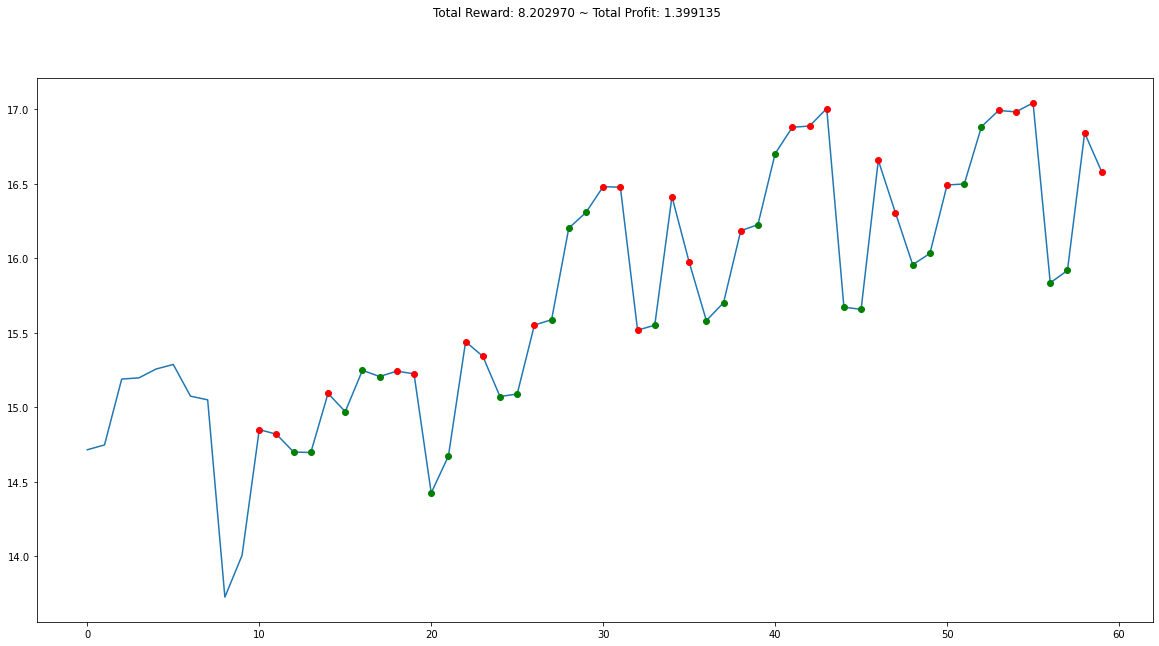

In [142]:
plt.figure(figsize=(20,10))
plt.cla()
env.render_all()
plt.show()